In [5]:
import os
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import csv
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

In [7]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [8]:
ROOT = '/mnt/data0/lucy/manosphere/'
SUBS = ROOT + 'data/submissions/'
COMS = ROOT + 'data/comments/'
SUB_META = ROOT + 'data/subreddits.txt'
LOGS = ROOT + 'logs/'
PEOPLE_FILE = ROOT + 'data/people.csv'
SUB_META = ROOT + 'data/subreddits.txt'

# Glossary matches

There is a list of words referring to people (PEOPLE_FILE) manually pulled from online glossaries about manosphere communities. 

In [2]:
def get_manual_people(): 
    """
    get list of words, add plural forms
    copied from find_people.py
    """
    words = set()
    sing2plural = {}
    with open(PEOPLE_FILE, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader: 
            word_sing = row['word (singular)'].strip()
            plural = row['word (plural)'].strip()
            if word_sing != '':
                if word_sing.lower() in words: print('REPEAT', word_sing)
                words.add(word_sing.lower())
                sing2plural[word_sing.lower()] = plural.lower()
            if plural != '': 
                if plural.lower() in words: print('REPEAT', plural)
                assert word_sing != ''
                words.add(plural.lower())
    return words, sing2plural

In [3]:
def get_subreddit_categories(): 
    categories = defaultdict(str)
    categories_rev = defaultdict(list)
    with open(SUB_META, 'r') as infile: 
        reader = csv.DictReader(infile)
        for row in reader: 
            name = row['Subreddit'].strip().lower()
            if name.startswith('/r/'): name = name[3:]
            if name.startswith('r/'): name = name[2:]
            if name.endswith('/'): name = name[:-1]
            categories[name] = row['Category after majority agreement']
            categories_rev[row['Category after majority agreement']].append(name)
    return categories, categories_rev

In [9]:
categories, categories_rev = get_subreddit_categories()

### Get counts by community

In [10]:
people, sing2plural = get_manual_people()

In [11]:
df_gloss = pd.read_csv(LOGS + 'glossword_time_place.csv', index_col=0)
df_gloss = df_gloss[(df_gloss['month'] != 'None-None') & (df_gloss['month'] != '1970-01')]
df_gloss

word  count             community    month
0          female    107  FORUM_the_attraction  2012-07
1             fag      8  FORUM_the_attraction  2012-03
2           mpuas      2  FORUM_the_attraction  2005-12
3             bro      7  FORUM_the_attraction  2016-05
4       hot babes      7  FORUM_the_attraction  2010-03
...           ...    ...                   ...      ...
291563     victim      3            mensrights  2008-03
291564      women      4            mensrights  2008-03
291565  feminists      5            mensrights  2008-03
291566   feminist      2            mensrights  2008-03
291567        she      4            mensrights  2008-03

[291445 rows x 4 columns]

In [12]:
df_gloss['month'] = pd.to_datetime(df_gloss['month'], format='%Y-%m')
df_sum = df_gloss.groupby(['month', 'word']).sum().reset_index()
df_sum

month      word  count
0     2005-11-01    female      1
1     2005-11-01      male      1
2     2005-12-01        ab      2
3     2005-12-01       afc    334
4     2005-12-01      afcs     31
...          ...       ...    ...
45163 2019-12-01  wristcel      1
45164 2019-12-01   wussies      3
45165 2019-12-01     wussy      1
45166 2019-12-01      zeta      3
45167 2019-12-01     zetas      1

[45168 rows x 3 columns]

In [13]:
def plot_word_over_time(w): 
    '''
    Plots the occurrence of a word overall. 
    w should be singular form
    '''
    g = sns.lineplot(x="month", y="count", data=df_sum[df_sum['word']==w])
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
    plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.title("Combined totals per category for word " + w)
    plt.show()
    
def plot_word_over_time2(w, community): 
    '''
    Plots the occurrence of a word in a community over time. 
    w should be singular form
    '''
    df_com = df_gloss[df_gloss['community'] == community]
    g = sns.lineplot(x="month", y="count", data=df_com[df_com['word']==w])
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
    plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.title("Combined totals per category for word " + w)
    plt.show()

/mnt/data0/lucy/anaconda3/envs/bert/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


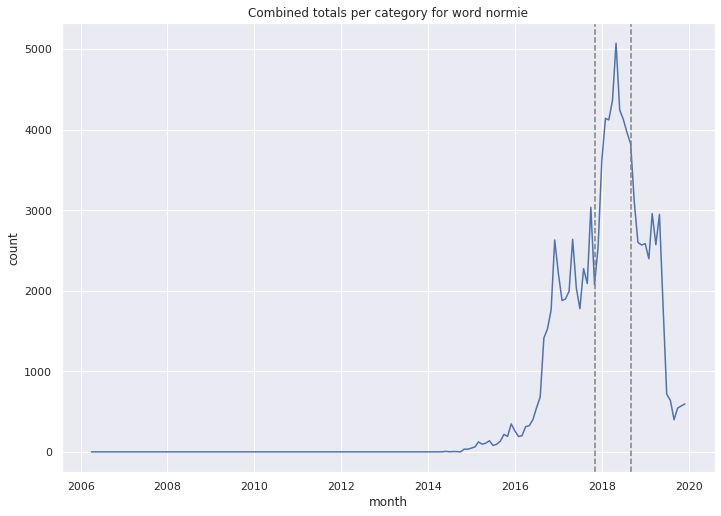

In [34]:
plot_word_over_time('normie')

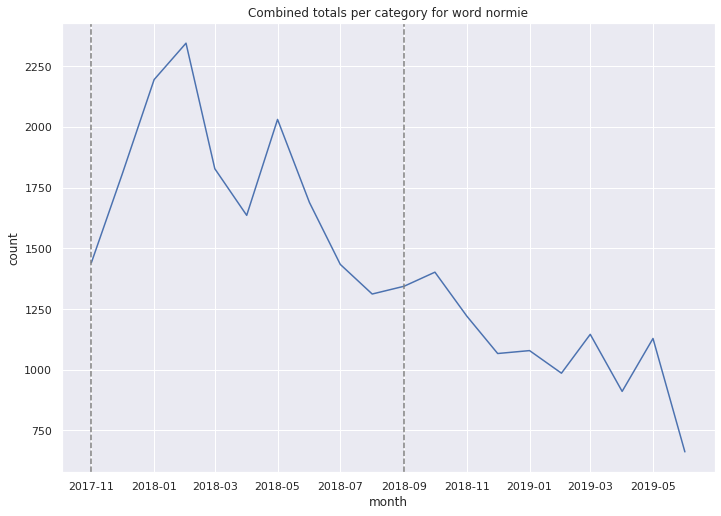

In [35]:
plot_word_over_time2('normie', 'FORUM_incels')

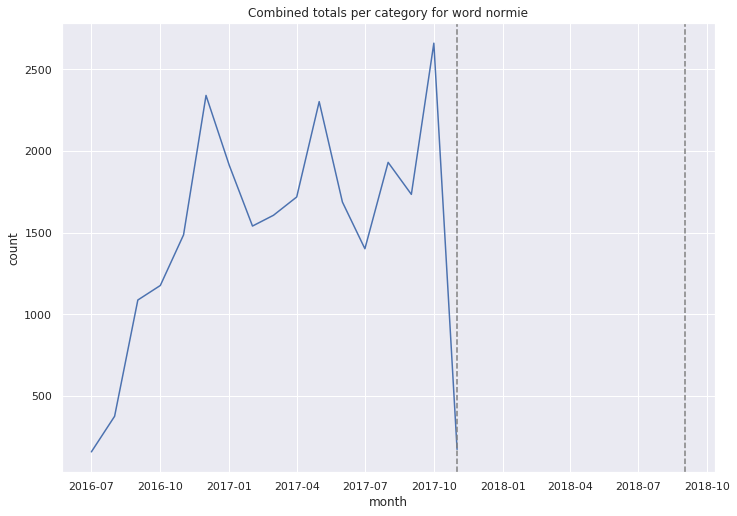

In [36]:
plot_word_over_time2('normie', 'incels')

In [37]:
w_df = df_gloss[df_gloss['word'] == 'normie']
w_df = w_df[w_df['community'] == 'incels']
w_df

word  count community      month
98130   normie    375    incels 2016-08-01
104651  normie    157    incels 2016-07-01
106875  normie   1176    incels 2016-10-01
120838  normie   1540    incels 2017-02-01
131495  normie   1718    incels 2017-04-01
132398  normie   1087    incels 2016-09-01
136522  normie   1687    incels 2017-06-01
137504  normie   1606    incels 2017-03-01
139791  normie   1486    incels 2016-11-01
143780  normie   1912    incels 2017-01-01
145634  normie   2340    incels 2016-12-01
165286  normie   2302    incels 2017-05-01
181293  normie   1401    incels 2017-07-01
186101  normie   1930    incels 2017-08-01
186988  normie    172    incels 2017-11-01
193916  normie   1734    incels 2017-09-01
200315  normie   2660    incels 2017-10-01

# NER tagged glossary people

We ran an NER tagger over the entire dataset and got even more mentions of people. We can compared these automatically tagged people with manually obtained glossary words. 

In [14]:
people, sing2plural = get_manual_people()

In [15]:
with open(LOGS + 'gram_counts/tagged_counts_full.json', 'r') as infile: 
    tagged_counts_full = Counter(json.load(infile))

In [16]:
total_gloss_counts = Counter(df_gloss.groupby(['word']).sum().to_dict()['count'])

Get the ratio of tagged counts to full counts for glossary words, and then plot a histogram of these ratio values.  

The assumption here is that words that tend to have many uses as non-people should have a low ratio (below 0.2). However, it seems like the tagger does not catch some glossary words that commonly refer to people. 

In [27]:
gloss_tagged_ratio = Counter()
for term in people: 
    if total_gloss_counts[term] < 500: continue
    tagged_total = sum(tagged_counts_full[term].values())
    ratio = tagged_total / total_gloss_counts[term]
    gloss_tagged_ratio[term] = ratio
for tup in gloss_tagged_ratio.most_common(): 
    if tup[1] < 0.2 and total_gloss_counts[tup[0]] >= 500:
        print(tup[0] + ',' + str(total_gloss_counts[tup[0]]) + ',' + str(tup[1]))

cunts,46151,0.19752551407336785
fag,17606,0.19714869930705442
hb,145441,0.19516504974525753
aspies,4538,0.19259585720581754
cunt,95358,0.19211812328278696
cum dumpster,2378,0.19091673675357443
currycel,6640,0.1891566265060241
wussy,2154,0.18802228412256267
robot,23791,0.18784414274305408
gf,196820,0.18776547098872065
cuckold,13785,0.18745012694958288
neet,16906,0.1872707914349935
retards,22659,0.1851361489915707
tribes,10186,0.1827017474965639
hater,9428,0.18158676283411115
manlet,37181,0.1805492052392351
nigger,17315,0.17805371065550102
orbiters,30031,0.17735007159268756
mangina,20361,0.17646481017631746
wageslave,2505,0.17644710578842315
feminazi,12940,0.17565687789799073
cucks,80899,0.1715843211906204
feminist,535539,0.17083349672012682
bfs,5620,0.16690391459074733
blackcel,2423,0.16673545191910855
conformists,547,0.16453382084095064
cum dumpsters,1123,0.15939447907390916
ricecel,4019,0.15924359293356558
foid,50573,0.15751487948114606
role model,10877,0.15316723361220924
boomer,6226

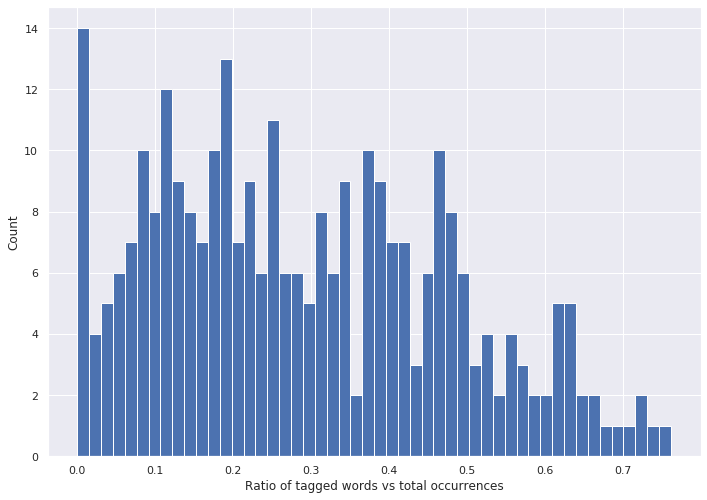

In [18]:
plt.hist(gloss_tagged_ratio.values(), bins=50)
plt.xlabel("Ratio of tagged words vs total occurrences")
plt.ylabel("Count")
plt.show()

Find cases where an entity is not tagged but still occurs in the text

In [20]:
def find_mismatches(w):
    month = '2014-05'
    occurrences = []
    with open(LOGS + 'tagged_people/2014-05', 'r') as infile: 
        i = 0
        for line in infile: 
            content = line.split('\t')
            entities = content[1:]
            for entity in entities: 
                tup = entity.lower().split(' ')
                phrase = ' '.join(tup[4:])
                if phrase == w: 
                    occurrences.append(i)
            i += 1
    j = 0
    with open(COMS + 'RC_' + month + '/part-00000', 'r') as infile:
        i = 0
        for line in infile: 
            d = json.loads(line)
            if w in d['body'] and i not in occurrences: 
                print(d['body'])
                print('----------------')
                j =+ 1
                if j > 20: break
            i += 1

In [68]:
find_mismatches('person')

&gt;But one day after some wine, she is inclined to do it? Is that still violating consent since she disagreed before but now is consenting / offering under intoxication?

I already said - this is not illegal, it's just *fucking shady*.

&gt;But if she actually agreed verbally, how do you know if she's really up for it or just drunk?

Wait until she's more sober, and **ask**.

&gt;Does it mean that as soon as alcohol touches someone's lip, consent goes out the window because even if they verbally agree / offer sex, it can still be rape since the decision was made under intoxication?

If you are incapable of judging how drunk someone is, don't have sex with that person if they've had any alcohol recently. If you're capable of telling the difference between when someone has had a couple drinks but they're fine, and when they should not be allowed to drive, then use your judgement.

You could always talk to someone sober about this and circumvent the whole issue, of course. My boyfriend a

I personally think the reason people frown upon it so much is because it hurts other people. You get to escape your pain, and not deal with anything anymore, but the people that you leave behind have to learn to live with the pain you created. That is why people see it as selfish, I think. I tend to agree with you; keeping someone alive while they are absolutely dead inside is torture, but you have to think of the people who care about you. 

I could be completely wrong though, this is just how I see it.
----------------
&gt; Brackish bitches concept. Some women thrive on the emotional abuse and drama because that is what they grew up on in their family life and don't know anything else. They aren't healthy emotionally, so cannot handle healthy emotional relationships and crave destructive ones because its what they understand. People aren't all necessarily healthy individuals and they gravitate toward certain types of people regardless of what is actually healthy for them

One of the 

Or you know, personality,  that makes up a lot.
----------------
Ugh, I can't think of anything that makes me more pro-marriage than watching another person's divorce. I've watched friends divorce and I'm pretty much willing to do anything to avoid that kind of trauma in my life. Especially with kids...it never really ends.
----------------
Personally I like 

&gt;I bet a lot of you guys could solve your dilemma with a modicum of personal hygiene.

As if we only shower once monthly and don't own a toothbrush or something.
----------------
I like it how dude replied to the linked study with his personal anecdotes about homosexuals. That's so STEM it hurts.
----------------
I see no problem with a lot of members being angry. To go with the Red Pill metaphor, do you think Neo was happy when he realized all his hopes and dreams were fictions made up to control him, and the real world is a wasteland owned by predatory monsters who use men as a means to an end? 

I'm not saying we should be 

I wish someone just told me;

Shut the Fuck Up. This is your biological drive. It's in your genes not your head. Relax, go for it, recalibrate, move on and repeat.

Look at your insecurities and stop being a bitch. Fix the ones you can. Get your ass to a gym or run outside, whatever. Invest in some nice cloths and a good face scrub. Get a nice haircut. Fuck the rest. Life is too short and too fucked up for you to be wasting your time worrying about shit you had no control over.

FUCK UP! But fuck up with a purpose. Whether it's getting out of your comfort zone or pushing peoples boundaries to better learn how to calibrate and not just getting a bruised ego(see above) or tiny dick complex.

Stop being a boy and become a man. Who is the person you want to have been when you look back on your deathbed. What did you do and what can you do? Start learning skills and hobbies. 24 fucking hours in the day stop jerking it completely(imo gets rid of AA and helps your game b/c you know that's the

Self worth plays a big part in this but it just goes so far beyond that. Self worth or no self worth, this is the girl I wanted to spend the rest of my life with. I wanted to make her my wife. I told everyone I knew that I was gonna propose to her. It took literally every ounce of me emotionally to even open up to another person, let alone let my guard down, be with her for five years, and feel comfortable enough to marry her. This girl was my first everything. She was my only everything. My first kiss, my first love, EVERYTHING. I don't really know anything about life outside of her at this point. Honestly, I don't want to. I've known my whole life there wasn't going to be a happy ending for me. I was stupid enough to actually fall for her bullshit and think that she wanted to marry me as well. It would be literally impossible for me to open up to another girl at this point. I can't even trust people in general at this point. She crushed all of that. I can't even interact with girls a

Here's another protip. Whilst having a pretty face is certainly an advantage for anyone (regardless of their gender), most people go for people with pretty personalities. So chances are, if you are an average looking guy, but have an amazing personality, chances are most women will find you more attractive than some vain, steroid abusing arsehole. 


If you are an average dude and spend your free time online spreading misogynistic generalisations about 50% of the population and refer to them on a numerical scale, refer to them as children and frequently dismiss any aspect of them that doesn't revolve around their lady bits, chances are this faucet of your personality seeps through when you interact with women.  
----------------
Nice story.

&gt; I wanted to prove that I had no need for her. If anything my refusal seemed to excite her more. 

I'm sure you will get people here that will say that you should should spin her.  As for me, well, my circle of friends generally agree that a go

&gt;Excellent passage, apropos. I'm not generally a fan of C. S. Lewis, but, still, it was good.

Most people make the mistake of thinking of Lewis *only* as the author of the children's "Narnia" stories; and/or they dismiss him as some naive "Christian" author -- in reality he was a significantly deeper thinker/writer than that, and while not in the line of the (so called) "high" philosophers (which lets be honest here, by the 20th century, had degenerated into an array of nihilistic-solipsism if not outright inanities), his adult works (especially the book "Four Loves") are IMHO *definitely* worth reading.

Moreover, while he did come from an era that engaged in what I suppose could be called a "chivalric" mentality towards women, it wasn't the entirely naive/pussy-whipped "chivalry" of the late 20th century.

BTW, in addition to Lewis, [some of Tolkien's non-fantasy stuff is also well worth reading... especially his "advice" letters to his sons regarding women/relationships &amp; se

Women LOVE to have their bullshit validated. Her desire to have you validate her past carousel riding and help her ascribe some modicum of value to her years wasted is constantly just barely held back by her desire to not be thought of as a slut. 

So what you do is that because she assumes you have a past, you "confess" something "slutty" you did when she asks you for info. As in if you usually dodge her questions, you just answer and convince her you two are not judging each other, just sharing cool adventures. 

Next you know she's bragging about how in college she was the girl who the crew team would pass around. Women desperately want to believe that they have found someone who won't judge them and more than that will help them hamster their flaws into diamonds. It is a very easy sell - I just tell girls, "don't be ridiculous, you can tell the truth. My ex was a stripper, I guarantee you're an improvement." Or "If I was one of those asshole guys who thinks men should get to fuck a

This!
I kinda feel like every job is this way.
I'm personally in a position where my last job, I tried to tell them I had issues and was seeking assistance, and they literally told me they didn't care and they just needed me to do my job.
A couple months later my friend killed himself and I had a breakdown and had some issues managing it and was fired.

Fast forward a year and a half later I'm in another job in another state and my mental health is falling apart again and I'm fearing I'm just going to lose my job in the process of trying to get help... Just making things infinitely harder to deal with.
----------------
I would argue that the difference between the assertive and the asshole is  more up to the person being acted upon. They decide based upon their feelz. If they felt you were disrespectful or mean to them, you're an asshole. They define what that word means, not you.

That's why there's no point worrying about semantics here. It's actually fun scoring some asshole points.

Men here. I'm basically in the same situation: I make $100K+ per year, work from home 100% and we just had a baby who is gonna be 3 months old. Girlfriend quit her job and takes care of the house full time.

I workout everyday, sometimes twice a day (weights + mixed martial arts)  which is my only "me time" I usually take, other than 4h of videgames every Friday. I do help around whenever she asks for help and I make it clear that I can't read minds - if she needs/expects my help with something, *ask* for it. That said, she's been doing really great: she cooks, cleans the house, takes care of the baby (I literally don't have to do anything, she wakes up every 2-3h to breastfeed). I offered her to pump some milk so I can watch and feed the baby on Friday nights so she can get a full night of sleep. I don't do the dishes but I always rinse them with hot water and leave it there so it's easier to clean when she gets to it. She's alright with that and if I start doing the dishes by myself 

Its just a test to see if you get weirded out / insecure / annoyed at the thought of her getting hit on. Just respond "I bet, you do have a great personality." 

Works on girls with bitch shields very well because its obviously sarcastic and somewhat of a neg. Obviously she says this primarily as a shit test, but secondarily as a way to get you to validate her by agreeing that she must be such a desirable woman. It's pathetic really, which is why you don't need to out verbally joust her with some expertly planned cocky/funny David D line like "Yeah, and how much do you think that girl over there gets hit on! She's stealing all your men. You should probably go over and start a catfight..." 



----------------
I was in a similar situation.  6 years ago.

It took me 5 goddamn years to get over her completely.  I doubt it will take you that long.  But.... even if it does.... well, I do not wish it to happen differently.  At least not often.

This was a huge journey, growing and improving 

----------------
There are a few things I didn't understand. So you say that there have been no major wars since WWII. I would consider the Vietnam War a major conflict, seeing as how there were over 2 millions deaths and it lasted more than 10 years. But my question is, what exactly does manipulation and females becoming a part of the war effort during WWII have to do with a lack of major wars since then?


Also, I do agree with how the media has planted in us men this false idea of what romance and relationships are supposed to be like. Until a few months ago, I suffered from oneitis. I believed that I had a soulmate and that women would see me for the sweet caring guy that I am. That real relationships were exactly as they are portrayed on TV. That I had to bend over backwards for women but that it would all be worth it in the end. That women were the noblest of creatures and that if I was lucky I would have the privilege to marry one and have children with her. I now realize that i

&gt; I can totally see why she did it

Dude, you're a giant pussy. There's no reason for any woman to cheat. If she wasn't a massive slut and a shit-tier person she'd break up and then go fuck another guy.

The truth is you don't value yourself or have enough dignity or self-respect. You shouldn't be making excuses for the person you're with fucking other guys, that's ultimate beta behavior.

&gt; Totally out alphaed in both cases.

Not an excuse for her to cheat, and you don't need to compare yourself against other guys you need to compete against yourself and always be self-improving. Just because there are better guys out there (there always will be) doesn't mean it's justified for your girl to suck another guys dick. Any girl can go get sex from a guy with higher SMV than her own SMV justifies if she goes to a club. But she'll never be able to lock down / get a guy with higher SMV than her into a relationship.

&gt; this girl has been letting me do whatever the fuck I want...it is 

The great thing about hating women is that no matter what her response, you can always claim that it was the more disrespectful answer.

I, personally, would feel **way** more disrespected if some woman told me "I wasn't good enough for her."
----------------
Yeah, but she says specifically one person, one person she's attracted to, she doesn't say "oh man I wish the man sexually harassing me at work was at least hot, that would turn me on". No. No. That's not how it works.

----------------
" But let's be honest. For every person outside of TRP who complains were misogynistic, chances are they encountered someone who was a little bit abrasive, angry, and may have even legitimately hated women at that particular point in time. But that should be temporary. We aren't robots, shit gets to us. We have to feel a little but of irrational anger sometimes because sometimes we just aren't rational. But there comes a time where you got to grow up and put that shit aside. I would hate for TRP to

I don't think it's cool to advertise one's salary to other people period, regardless of what gender you are, regardless of whether or not you are married. The same goes for peacocking around about who the breadwinner happens to be, whether or not they know specifically how much you make. Whenever I have seen these situations come up, everyone seems to get really awkward and uncomfortable. What purpose does it serve, other than bragging and making one seem superior, even though it doesn't really put anyone above anyone else. It seems unclassy, tactless, and it is still a sensitive and taboo subject for a lot of people, but I of course can't speak for everyone. I personally just don't think it is anyone else's business. 
----------------
No no no, you don't understand, this is just one person's opinion! You're cherry picking! NARPALT!!!
----------------
I have decided I won't be wasting any more time debating paternal surrender.  We might just as well debate how many angels can dance on 

Only if the escort sucks at her job. Their clientele are people just like OP. The type of person who just wants someone to masturbate into is usually the type to pick up streetwalkers. OP wants to bang someone, but he also wants the feedback of someone wanting to be banged like he would in a normal relationship.

Escorts know that the sex is the crux of their work, but for a lot of guys it's simply feeling that companionship a hooker won't provide. That's why OP wanted to get to know and have dinner with his escort. It would've been cheaper and right to the point if he only wanted to masturbate into a person. 
----------------
This.  Master having friendships (plural) and chill the fuck out.  Do that for a year, know many cool people.  Focus on having those good relationships and grow your character.  I guarantee you will find all dating related steps easier when you are more of a person.
----------------
I didn't even know that "not eating alone at mcD" is a thing.

It's a sad fact th

Although I really can't say for sure, it helps that you were willing to put yourself out there. 

Based on some of your past contributions, you also seem to have a very creative personality, so making these types of things is a part of who you are. Either the person will appretiate it or they will not. I know presentation plays a big part in what is considered sweet vs. creepy, but most of these actions seem pretty cool. 

Side note: That Monopaly card was awesome!!! The big one and the little one. I also liked your Colbert shirt and your "favorite" shirt (please tell me you still have that). The advent calender was a very sweet idea. 
----------------
I currently have one lover and one friend-with-benefits.  Both of them have been with me for over 8 months, and there has been absolutely zero drama.  Before that I was with my girlfriend of 3.5 years, and the only drama occurred near the end of the relationship when we had already lost the spark of attraction for each other.

So when yo

Yep. Also just to add (late): I added certain terms that I found in other "seduction" glossaries, that I *myself* may not agree with. I tried to make mine a bit more "friendly" for beginners, but some of the terms were simply too well-known for me to ignore. 

"Spinning plates" might be on there, but it's not like I agree with the idea -- I just put it on there because it's fairly common within the community. 

Like you mentioned though, "k-close" is simply when the interaction ends with a kiss. Saying "the interaction ended with a kiss" takes much more time than simply saying "k-close," and that's really the only  reason why we use short-hand for that sort of thing. 

I *personally* don't usually use short-hand in that situation, because I *do* think it's kinda weird, but I can totally understand why others use it. Same reason we use HB8 instead of "Monica, who was pretty hot" -- for one, we don't want to use the person's actual name. Two, we don't want to draw on the story when only 

I don't think that offering to help him is unacceptable, but I also wouldn't bet he will accept it. Is it the financial burden or finding the time that is the bigger issue? Wherever he is, is there anyone else known to you that you could talk to for more information? Is he religious? Could he talk to a pastor or a priest for some guidance towards some help? Often a local clergy person knows of available help in the area. I am afraid that mostly you are stuck with trying to be supportive, but unable to really intervene. I hope you can find a way to make a difference for your friend. Best wishes. 
----------------
I'd kinda prefer Canada shut it's fucking immigration off for a while. That's just me though. Or slow it down ffs. in 4 years Canadians went from being Canadians to feeling like a minority in their own country - at least in large cities, Vancouver is like a mini Hong Kong I'm told, every business I've see in Edmonton has had an  
East Indian or Pakistinian owner and all the wor

First thing: Don't lose hope. Depression is beatable. Beating depression doesn't even require "strength". It requires knowledge. Knowledge and patience, and just being able to cope with your feelings while you learn how to deal with and eliminate your depression.

Reading your comment, yes, I'd say you should go to a doctor and talk to them about how you feel. Suicide fantasies (the whole "knife looking friendly" thing) are serious business.

You should go and see a doctor because, even though I can talk to you and tell you "*Yeah*, you've got depression" (and, *yeah*, you've got depression), a doctor can tell you whether there's anything else there that's complicating matters for you.

Some people can see getting diagnosed like it's the beginning of being stuck with whatever you're diagnosed with. It really isn't. It's the beginning of *ending* what you're diagnosed with. For most mental disorders, diagnosis is the beginning of learning how to cure yourself. For anything that's not a 

Hmm...yes. don't ever let anyone play you like a little bitch, unless that person is your employer.
----------------
you do get to hit someone because you think they are about to cause grevious bodily harm. 100% you do. its got nothing to do with what the other person is thinking. i have gone over the australian laws and what happens is if you can justify that you were scared for your safety you can defend yourself. she will have to defend it but this is the law. i just checked the US law, i spent some time trying to explain this to you but if this doesn't do it you have to understand you are a zealot.

483 F.2d 1222: United States of America v. Bennie L. Peterson, Appellant

the report states that there must be "foreboding" fear of injury which very much applies to this situation as is. 

And for the record i don't think this guy was going to hit her, but the problem isn't either of them for you, its the law, and i see the best course of action is her being unable to justify that he w

It's a non-issue. Presumably you don't marry/commit to a man who is unwilling/unable to fulfill your needs. After you find the one that does, then you devote yourself to making him happy. If you've committed to a man before you've answered the question "what does he do for me?", ya dun fucked up.

Both TRP and RPW heavily emphasize personal responsibility/agency. Ultimately, you can't "make" anyone else do anything... But you can always change the way -you- behave/react. I still dunno why this is such a difficult/radical notion for certain people to get their heads around. 

They seem to think an RPW just takes any loser off the street and spends the rest of her life taking crap from him because he has a penis, which is laughable. My bf doesn't give me crap. He loves and takes care of me, and I love and take care of him (albeit in different ways), and we're both really happy (gasp!)
----------------
I don't think you understand these ideas. 

You also probably think your relationship i

Yeah I want to keep her because things were great at one point, but I was a different person then. Wish I could get right back into that state of mind.
----------------
I support the movement, obviously, because I'm tired of the rampant feminism and the way the justice system dicks over men while giving special privileges to women, but nothing's going to come of it. Women are incapable of empathizing with the issues of anyone who doesn't have a vagina.

MRM's have taken the first half of the pill - recognizing that no one in society gives a shit about your issues if you're a man. They haven't yet taken the second half, which is where you realize that the only person who can save you from the fucked up system is yourself.
----------------
In my own personal experience, it's the most sensitive people who experience depression, anxiety, and a whole host of other problems much more strongly than others, and it's precisely because we care the most. If you didn't care, you would just stumble

Thanks I'm glad to know that some people try to see that I'm not that bad of a person.
----------------
Looks like it's time to smell the roses .....time to do what u do best.... fuck everyone  that gives u the urge.... shouldn't be too hard.... after all.. u are the spawn of the lack of importance and the finger it points..... try to look at what u want.... waana fix it...go for it.... wanna move... whose stopping u..... can't seen to figure out the next plan.... well maybe..... communication. Is the ultimate key......  just like u lost ur significant other... the lack of talk....  no wonder he fucked up.... so he can feel better after all that pain and anger inside..... but u don't care...ur only out for urself..not even ur kid.... pathetic of a person... at least the one who fell.. stands tall and looks down at u and laughs... he  is happy for the rEason of moving forward. .... oh by the wa y.... messasge.... only one shot or it all goes away... either talk.... or ... look away. ...

Be a generous person. Don't tell people you will change. Just change in your actions, and all will be fine in 6 months.
----------------
yeah self diagnosing yourself isn't exactly valid is it? This subreddit isn't just about spreading depressing stories and milking attention, its a place where venting is allowed and that people would listen and contribute to discussions. being listened to is just something phenomenal and its a key step in recovery so please the last thing we need is an ignorant person who hasn't gone down the same road to judge the meanings and purpose of this community 
----------------
&gt; If she does view abortion as murder, she won't get an abortion.


I would like to change my original phrasing from "murder" to "the killing of a human". Then everything I say stands. And it can't be murder if it's not a person legally yet. If he did this is the third trimester he should get all the charges I mentioned in *addition* to murder.


The morning after pill isn't murder

The most we can say now is that we are unsure exactly how much "attraction" is based on biology vs culture. However, where does that leave the idea that gay/lesbian and transgender persons are "born that way"? I tend to believe such things *are*  biologically generated, but that means that straight (or "cishet") people are *also*  born *that*  way, and by extension that biology *does* play a very significant role in determining "attraction". Even if we can't quite quantify *how much*  of a role it plays, it is apparently a not-insignificant factor. 
----------------
&gt;they just have driven most of the males out who could fit that role years ago even if it was unintentional. 

Describes feminism in a nutshell at all levels across every society it infects.

Men are dropping out, and not just out of churches, from education, from employment, from starting families. Let it all tumble, fuck it. Society has forgotten what it means to value the masculine. Many men are mentally and emotional

Everybody complains. Its to let out some frustration and anger. I think its necessary and healthy. The alternative is to beat the person you are angry with, or someone else, damage property, brake plates lift etc. Some are not harmful and some are. Complaining isnt. Its only annoying if it never stops and keeps repeating for the same things 
----------------
I couldn't even read some of the replies because I couldn't wrap my head around their reasoning. What really got me was the person who was saying that their relationship is very similar to many of ours but that it's the "inner workings" or "philosophy behind it" that gets them. You mean you're still pissed we're in happy relationships just because we do it differently? Good job.
----------------
Did you not read my above comment, or did you just reflexively downvote because TRP?

Responding with happy aloofness and having outcome independence is not:

&gt;you should call her a fucking bitch and a whore because she chose someone els

It's a perfect example of society expecting men to just 'take it' and be stoic. It shows that male on male violence, or female on male violence is hilarious and acceptable. 
How many rom-coms have you watched where the girl decks the 'douchebag' character, or another person? I can name many just off the top of my head. It doesn't matter to people - that's comedy. Reverse the roles, and watch the cinema go silent. 

Of course people are justifying it. Not only is Jay-z not the most likeable person, but the idea of a woman being violent doesn't sit well with many. They need to silence their cognitive dissonance. 
----------------
Wait, tell me what you are saying. What I'm reading from your language and your analogy is that women act "foolishly" by wearing revealing clothing and are resultantly complicit in their assault.

Its not so much a question of women not being careful, but the extent of care they are expected to take when out in public. 

*Skirt a couple of centimetres too far up

Hey man, sorry to hear about your situation. Getting caught up with the law, especially for something so small, fucking sucks. However, it doesn't mean you're a bad person, or even that you do bad things. When it comes to possession, it's usually just a wrong time/wrong place kinda thing.

It sounds like you really need to talk to someone about this. I know that's hard, but you could try talking to a pastor or counselor in your area. If they can help, great, if they can't then there's no harm done. You probably won't ever have to see them again if you don't want to.
----------------
Let's see how I have fit into this so far, shall we?

&gt;**Waitress**

&gt;That’s more like it.
Sexual Satisfaction Rating:  7/8th erection
Long Term Potential Rating:  1/2 carat\

...I was in high school...regardless, he wants a woman who probably has to live paycheck to paycheck? that sounds like a recipe for avoiding women who use your resources, for sure!

&gt;**Artist**

&gt;Every man should experienc

What do you mean by "strong" and "capable?"

Also, saying you're smart means nothing, really. It's not the initial thing guys look for. Intelligence only matters once you've gotten past the first impressions.

What is your personality like? A bad personality will be offputting.
----------------
I didn't say anything about being ashamed with connecting with others via the internet. I said to check your emotions before using the internet. There are a million other people who could potentially respond and not being prepared to read bad or good is not attractive. The ladies here who know me a bit know that the IRC chat and this forum have given me a lot more confidence in being as young as I am with this frame of relationship, which is very strict. A debate is great and all, but I think you are just misunderstanding what I was pointing out about being nice in relation to my comments throughout not only this sub, but reddit itself and my life in general. I also never said emotions were bad,

Let's not play the fake as hell feminist who pretends to care about the poor people in the third world when they barely can get poor women's issues in America on the agenda because their leadership is too busy chasing seats on corporate boards and top executive jobs with initiatives like #banbossy for example.  How about shifting focus to women on tech while ignoring minorities in tech. Let's not pretend this enterprise of primarily privileged white women manufacturing victim status by playing up disparities driven by women's own personal choices amounts to a real human rights campaign to aide the disadvantaged.  Poor women like women of color are nothing but tools to garner attention for an establishment mainly concerned with advancing themselves by coopting the issues of others. 
----------------
...

1) How much effort you're willing to invest in a person is generally a function of how much they would invest back into you (unless you love them, in which case you don't care how much 

I think your a strong person for even having dealt with it for such a long time. I don't think I could last 8 years nor do I think I will the next 8. But atleast you've got something you can kind of escape even for a little bit, even if it doesn't take the pain away completely. 
----------------
I am just a lurker. I might have posted here once or twice. Yet it makes me feel better that I am not the only person who feels like an unloveable loser for just wanted a nice committed, loving, intimate, etc relationship.

But hey I am almost 23 and still have yet to kiss a girl. 
----------------
your info on ECT is outdated and inaccurate. (And by the way, they still do perform lobotomies, but they are last resort procedures and you have to go through extensive analysis and consensus from multiple docs- and the procedure has been reformed quite a bit from 40, 50, 60 years ago). 

 I'm sure you'll find a few anomalies that had that severe permanent memory loss, but you'll also find people who

thanks. yeah, have the decency to do it.  its just that awkward conversation though because someone is going to be upset not matter what.  ive learned to just say fuck it, youll never see/talk to that person ever again. we'll both get over it.
----------------
&gt;In a statement, an independent, student-run online news site said it demanded that a staff member named on the list "permanently and immediately resign from their position." "Our decision does not reflect a position on the innocence or guilt of this former staff member, nor does it comment on, take a position on, support, implicitly or explicitly, any allegations of fact or law made against such person," the statement said.

*I take """no stance""" on your innocence or guilt, but I think that you should be fired ("permanently resign") because someone wrote something about you on a wall.*

These people defy all logic. I've said it once I'll say it again: **accusation--specifically in this situation--does not equal evidence.** 

Actually your assumption is incorrect. I know from first hand experience. Even in Texas (one of the least liberal states in the country) I was repeatedly told by my psychiatrist that if I ever needed my medication and was unable to get it (either because insurance problems, because I could no longer afford it, or even if there was just a delay getting my prescription at the pharmacy) to come to them and they would give me enough free samples of the product to get me by. She also told me repeatedly to apply for assistance in paying for my medication and that I should never think that I couldn't take the medication I needed because of money and I should not assume I am ineligible just because I'm employed.

This is what the OP should do--she should talk to her doctor (or call her doctor's office in order to avoid paying for an office visit.) I never applied for any kind of assistance, never took my psychiatrist up on her offers for free samples--I just suffered because I assumed I would 

Yeah I think its a "power word" just like "slut" is.  Its a word used to try to control another person through judgement.
----------------
"It's not about feeling bad about something, it's about removing those things that elevate one person above another based on unearned and involuntary criteria. "

I have a better idea_ why don't we *add* the things that elevate one person to another to the person that is being left below? Most of these thing are not privileges anyway, they are rights, rights that are denied some people. That difference in access to what are rights is what is misnamed "privilege".

 Women are generally after in public than men are when it comes to violent crimes - do we really want to make women less safe? Is that the kind of equality you are arguing for? That women suffer the same rates of workplace death and injury? 

It is quite telling, BTW, that those who argue as you do for removing disparate advantages only ever talk that way about the disparate advantages men

Well I guess if I'm going to have a long term relationship I'll have a discussion of their values ,  to make sure we see eye-to-eye before I fully put my emotions into that person
----------------
No, I'm saying you don't "get a chicks number" at the super market.

Instead, you "plan to get drinks with a chick" at the super market.

Don't call her to invite her to anything, call her to confirm your plans or set a date/time for the plans she agreed to in person.

And yes, no need for any kind of comfort, because she already enthusiastically agreed to the date in person. 
----------------
I'd disagree, actually. The 'support' she's getting generally hasn't been in her favour. The top comment right now is "both of you need counselling". There's a lot of posts saying she should go to the police herself. This isn't "oh it's not so bad" support, this is "you screwed up big-time and this is what you need to do" support. They're not *murdering* her for revealing she raped someone, but... well,

The world, to me, often feels like a besieging army. I feel trapped by the nightmarish hordes of humanity outside of my walls. Human beings are capable of terrible things, amazing things, and (maybe worst of all) banality and apathy.


I consider myself to be a banal person. I don't contribute much, my happy moments are small and personalized and usually selfish. It's sometimes hard for me to see the good in that or in others. However, minimizing harm, I think, is better than nothing. I try to accept that many people may at least be trying to minimize harm to others and that I am doing the same.

People do often seem happy. I think, although I can't really know in most cases, that "seem" is the key word. I have a tendency to view other people as two dimensional characters in my life. What I see is what I get, for the most part. I have to remind myself that that has almost surely never been the case. People, like myself, are multi-natured. We can have conflicting ideals and continue to 

Short guy here. I've been pushed around in public places and accused of lying about my age. Bitchy women do that. 

The men that have pushed me around have been vapid pricks that need a punching bag to validate themselves in front of women, demonstrate higher SMV than me. But that's not being alpha; it's being a douche. 

"Judge a big man's character by how he treats little men."

**I don't mean to make a pity party here. No, It doesn't happen that often.** 

And in fact it motivates me to improve myself. I am an ambitious and motivated person, respected for my personal accomplishments and intelligence among my friends, if not physical stature (Planning on starting a gym routine this summer). Nobody ever fails to stick up for me when I hit the town with my friends and some douche wants to step on me. I have good friends.  
----------------
I'm turning 19 soon and in the same exact place as you bud! Just finished my first year of college and got my one way ticket to the 'friendzone' whe

I dont mean to brag. Just annoying getting rejected because of your personality and hep c.
----------------
"Beware your SO's personal trainer."

PT here (part-time, in school). I'm pretty cut, intelligent and can turn on the charm when I need to. Married women talk shit about their husbands constantly, girls in relationships assiduously hide the fact they have boyfriends, single girls view each appointment as a date and dress/act accordingly. 

Once I start fucking one (which is usually initiated by them), they tell me from the first session all they could think of was me bending them over a bench, sneaking away to a hidden spot in the gym, etc. I could write pages on the depraved shit these women come up with. 
----------------
Yes. All this. The next developmental stage is for her to really get what sex is for you. That the two of you are exclusive and monogamous and that for you making this commitment is not trivial. She is the one person with whom you are having sex. This is not a

That's one of my biggest fears- watching people from my batch grow and go to university while I'm struggling to even stay alive. I'm going to talk to my therapist about this and see what comes out of it. Hopefully I will get my mother to understand my mental struggles, and then work out a plan that will benefit me mentally and academically at the same time. 

Thank you for your input. I am really happy that it worked out for you. I wish you all the best; you seem like a really empathetic and intelligent person. You really deserve all the good things in life. 

----------------
I personally wouldn't, and I think it really does establish higher value to say no. For one thing, abundance mentality means that *you* get to be the picky one, and can easily find a single girl instead of one who's too cowardly to break things off with their current beau. You don't need those people around, because you're better than that. 

Also, being "that guy" never reflects well on you. Sure, it's not the e

Dress like be the person you desire to be. Feels like peacocking  at first, but eventually it feels gross to not look hot/intersting/confident/wealthy/fun/manly, because if you dress like everybody else (without much consideration) its boring and displays less self-respect.
----------------
It's a stereotype like any other. This just seems so extreme cause it's about such a large population. The best way to change a person's view on this is to be consistently different from it. It's really win-win when you think about it.
----------------
Well, no it doesn't first of all. An asexual person can be gay or straight.

But second, see AlbrechtVonRoon's point above. Men in prison sometimes rape other men. Does that mean they are gay? No.

For that matter, there are all sorts of ways you can harass people right? I saw a friend bullying/harassing another male friend (both were straight) in a way that would absolutely be called sexually harassment if it were opposite gender (pulling down the vi

I don't think it's even necessary to say that.

Especially over text -&gt; the best response with texting is very, very often no response at all.

In person -&gt; I'd use "why are you so hung up on this?" with a grin and make fun of her for it. Start roleplaying that it's her obsession and tease her about being some sort of therapist.
----------------
I am so sorry to hear that you are feeling so awful, and I can understand where you are coming from (been there, done that).  Unfortunately, my 15 year old son is also in a similar boat (with the depression and loneliness), so I will tell you what I have been telling him:  you cannot base your self-worth on  what another person thinks of you.  Otherwise, if something does happen to the relationship you are left exactly where you are now.  Further, you need to be stronger and confident in yourself in order to have something to offer a potential partner.  Any relationship that you might get into while feeling so worthless would be with a wo

There are many variations within the simple menswear shape that you can easily convey your personality and style
----------------
Slavery also worked for eons, but then we were all like, "Hey, something is wrong with this." I agree with that notion. My prerogative is that is everyone may pursue their desires, so long as it doesn't interfere with the well-being of others.

I'll humor you, though, for a moment. Lets say that it's true, that women feel no empathy for men. Now, why should the lack of empathy discharge a person's right to vote?
----------------
Good. It sounds like she just bought into the feminist teachings that men are out there causing all these horrible things and that some men as "the enemy", and simply never considered the male point of view. Her initial reaction was wrong because she never thought much about it... not because she's a crazy anti-male female supremacist.

I think some of the comments in here are going too far, assuming she must be a terrible person and

I think this is a great idea.  Get the cutest fucking dog in the world with loads of personality.  He/she will do the opening for you - all you have to do is not suck.  Also, if the plan fails, you have the cutest fucking dog in the world to help cheer you up.
----------------
I would say that the shoe is actually on the other foot--victims are supposed to be shielded from scrutiny so that they DON'T feel like they have to "come forward" and be judged simply because they are the victim of a crime.  I have no problem with rape shield laws--I in fact think they should be extended to all parties of the alleged crime until conviction.  While it is important to have the ability "to meet your accuser in public court," the court of public opinion is MUCH larger than it used to be and the stigma of a rape accusation can extend into every area of a person's life, legitimate or no.

The reason why I think that the discussion should be focused instead on perpetration rather than victimization is 

A form to potentially limit your freedoms in a way that endangers your life? Yep. I'd say that's pretty damn serious.  

How bout you fill out a form for me where if you do I may one day show up and make you kill people. If you do it you can live life like everyone else if you don't then you have to give me $50,000 

Your not filling out a form you are giving up your personal autonomy. The same thing autonomy that feminists fight for.
----------------
It could be a function of where you live but online dating is by far the easiest way to get laid. BY FAR. I do however recommend a pay site like Match.com vs the free sites if you are going traditional online dating. Coffeemeetsbagel.com is free and ok if you are struggling as they only match you with 1 person a day so not a lot of competition. I've written a lot about online dating on my site which you can check out www.joshsway.com.
----------------
[I'm assuming you're in the U.S.]

In college, there were two categories of Indian guys.

I like coming clean up front. I don't want her thinking shes done something wrong when im just having personal issues. Just tell her what im dealing with on a daily basis. I dont go into too much detail, because buzzkilll, but it helps to lift some stress. It doesn't do anything to stop putting yourself down, you gotta work on that. Sometimes girls just say, ok. Others are super inquisitive. I like the second
----------------
http://www.reddit.com/r/ForeverAlone/comments/263sh3/dae_see_douchebags_in_relationships_and_think/chngc01

OMG so much Misogyny on /r/Foreveralone. "I don't think I deserve to be with someone. Yes I do want to have someone special, but do I deserve such a person? Bad personality, overweight, below average looks, can barely support myself, have no specific skills." this quote might as well be on the /r/theredpill front page

how does /r/thebluepill put up with so much misogyny in this thread. lets brigade them wymenn
----------------
It's not really "game" unless 

Agreed. Awkward people tend to think silence is really uncomfortable. As long as your conversation generally has a good flow, a couple of silent pauses can be used to your advantage. Showing her that you're not uncomfortable even in silence when meeting a person, and using it to escalate, is a pretty good move.
----------------
You highlight a very red pill quality "learn to walk away"

I've walked away so many times from women, arguements, situations, you name it, it is a very very good quality.

I've actually sat opposite some dogs and downed a shit load of alcohol, fucked them then left, because I wanted my fix, but this was when my self esteem was low.

Now, I don't give a fuck. And in regards to Tinder, its great as is all social media for poon tang. 

Think about this, a girl is more likely to give you her number, meet you and sleep with you nowadays online than in person. 
----------------
To some degree, I don't care. Granted, the story is more valuable if true, in a couple not

While not the greatest opener, it's a numbers game. Those chicks just weren't receptive. You can't control others reactions to you, you have no idea what's going on in their heads. 

Maybe the cold girl gets anxiety or is generally an unpleasant person, maybe she just got off the phone with her mother who is hounding her about something, or she is irritable because she's hungry. 

The point is, don't get hung up on this.  
----------------
I wouldn't do that, if the question comes up it's considered to be a shit test. I'm thinking more along the lines of presenting yourself really well, as a successful and attractive person, whose presence can be felt.
----------------
Not exactly. Women are attracted to different things. Having a good looking body is definitely beneficial to picking up the ladies, but your body by itself won't make them drop their panties.    
Having a killer personality, status, charisma all are far more attractive to a women than a six pack.  
Don't get me wrong, a 

Having a vagina doesn't give a person carte blanche to assault others.  Help her learn this by reporting her to the proper authorities.  Make sure to use the witnesses who saw her attack.

You won't have to worry about seeing her daily when you have a restraining order put on her.  Make that happen.  Fuck that violent thug.
----------------
Depends what you want, doesn't it? Sometime you can see quality in a girl but the bitch just hasn't been trained to be a decent person yet. You can always cut and run at the first sign of trouble, which is by far the safest tactic because, as illimitable man was talking about; you really don't want your sense of reality undermined by a gas lighting succubus who can do untold psychological damage simply in her attempts to weasel out of admitting wrongdoing. 

The simple fact is that none of them come out of their wrapping properly finished. They are children and all the games they play are the same ones they worked on in their childhood. They practic

Can you go into more detail. How do you know who has the power? Would it be whoever cares less about the other person I'd assume? And what if the motivation is strictly just to chill out and have fun? I mean does a beta-orbiter literally think the ground some chick walks on is gold or something?
----------------
It illustrates that I'm a different person from who I used to be... other than the Mozart. I loved Mozart before TRP.
----------------
I think there's another way of looking at this statement. This is mostly for the sake of other viewers, so please RPS don't think I'm trying to lecture you.


Banging hot women is a goal, and a reasonable one to be sure. But this statement seeks to encourage men to seek PRIMARY missions beyond that. It is, in other words, the Empire Builder's viewpoint. It suggests that a man should focus on building Rome as his primary mission.


It need not be seen as a dodge or cover to protect the ego of men who fail at the side mission of banging hot chicks

From your post, it seems like you're uncomfortable with parts of your past which you're ashamed of. You're intelligent and understand the importance of reaching out and reflecting on your thoughts. 

Everyone has made choices that they could be ashamed of -- but just because you've make mistakes, doesn't mean you're a bad person. Don't be so hard on yourself. The past doesn't define the future!

Lots of people care about you and you probably have much to offer :-) Keep your head up and don't be hard on yourself! The second you forgive yourself for past mistakes, and promise yourself to not repeat them, you're a better, smarter person already. 
----------------
Camrys never seem to be able to get the low bass right. They have decent treble and thumping midrange, but with low bass it gets messy. 

Yeah, I lost of lot of weight this year because Ive had to scrounge leftovers from lunch for dinner. Im pretty sure with my metabolism and walking to class, my weight would stay healthy even wi

KeyboardInterrupt: 

## Annotated vocabulary

In [39]:
ANN_FILE = ROOT + 'data/ann_sig_entities.csv'

The cells below do the following
- examine common prefixes and suffixes to bigrams
- check cases where I marked Y but the people occur more often as proper nouns 
- check cases where I marked N but the people have "a" or "an" as a determiner (to avoid missing a proper name that represents a persona)
- check that plural and singular forms of a word are consistently labeled Y 
- see if spreadsheet words in urban dictionary or wordnet

In [59]:
prefixes = Counter()
suffixes = Counter()
vocab = set()
with open(ANN_FILE, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader: 
            if row['keep'] == 'Y': 
                vocab.add(row['entity'])
                if row['labels'] != '':
                    labels = json.loads(row['labels'])
                    if 'prop_per' in labels and 'nom_per' in labels: 
                        if labels['prop_per'] > labels['nom_per']: 
                            print('Y PROPER', row['entity'])
            if row['ngram'] == 'bigram' and row['keep'] == 'Y': 
                contents = row['entity'].split(' ')
                if len(contents) < 2: 
                    print(row)
                prefixes[contents[0]] += 1
                suffixes[contents[1]] += 1
print()
print(prefixes.most_common(30))
print()
print(suffixes.most_common(30))

Y PROPER mgtow
Y PROPER chad
Y PROPER op
Y PROPER chads
Y PROPER sjw
Y PROPER hb8
Y PROPER stacy
Y PROPER hb9
Y PROPER john
Y PROPER hb7
Y PROPER meeks
Y PROPER tyrone
Y PROPER mgtows
Y PROPER brad
Y PROPER christians
Y PROPER hb6
Y PROPER stacies
Y PROPER europeans
Y PROPER chadlite
Y PROPER germans
Y PROPER noone
Y PROPER valentine
Y PROPER gangbanger
Y PROPER stacey
Y PROPER becky
Y PROPER superman
Y PROPER duke
Y PROPER antifa
Y PROPER hb5
Y PROPER leo
Y PROPER romans
Y PROPER canadians
Y PROPER tyrones
Y PROPER brits
Y PROPER turks
Y PROPER stacys
Y PROPER wymyn
Y PROPER casanova
Y PROPER swedes
Y PROPER amish
Y PROPER slavs
Y PROPER hb4
Y PROPER soviets
Y PROPER beatles
Y PROPER staceys
Y PROPER tenmagnet
Y PROPER poc
Y PROPER jockcel
Y PROPER slav
Y PROPER filipinas
Y PROPER hb1
Y PROPER stacie
Y PROPER pajeet
Y PROPER spaniards
Y PROPER chadpreet
Y PROPER eskimo
Y PROPER ukrainians
Y PROPER ashkenazi
Y PROPER hb2
Y PROPER mongols
Y PROPER maverick
Y PROPER beckies
Y PROPER shor

In [14]:
def find_examples(month, w): 
    '''
    Print some examples of a word
    '''
    j = 0
    with open(COMS + 'RC_' + month + '/part-00000', 'r') as infile:
        i = 0
        for line in infile: 
            d = json.loads(line)
            if w in d['body']: 
                print(d['body'])
                print('----------------')
                j =+ 1
                if j > 10: break
            i += 1

In [15]:
find_examples('2019-05', ' ss ')

all three are chad but broly is the chaddiest. the green alien chick was on his dick hard the moment she laid eyes on him. broly in his base form mogged vegeta and goku who were ssg/ssb hard. ss broly mogged them even harder. it took gogeta(ultra chad) to take broly down.
----------------
I don't understand why did they post that gary's ss on r/niceguys. Just coz he places facts against women? lmao
----------------
That stupid imgur link means I can’t ss this
----------------
brazilian truecel will probably ss this with some lame humourless title like ''because i totally live in the favela /s''
----------------
Its not that hard, with just 15 minutes i can ss and crop double the images
----------------
Exactly.... "I will contact you IF I change my mind" I was like: GOTCHA. Still smirking lol. Hell no! What do you take me for? I am handsome, my face is fucking sweet, high cheek bones sticking out like those waffen ss posters, perfect shaped eye brows and eyes, good nose... That's why s